In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# loading the feature matrix csv file
featmat=pd.read_csv("E:\\Data Mining\\the-toxicity-prediction-challenge\\feamat.csv")

In [3]:
featmat.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V1066,V1067,V1068,V1069,V1070,V1071,V1072,V1073,V1074,V1075
0,60-35-5,178,59.037114,-0.808,43.09,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,103-90-2,1983,151.063329,0.870,49.33,0.0,0.0,0.0,0.083333,0.142259,...,0,0,0,0,0,0,0,0,0,0
2,968-81-0,1989,324.114378,2.960,100.72,0.0,0.0,0.0,0.185395,0.161948,...,0,0,0,0,0,0,0,0,0,0
3,520-45-6,122903,168.042259,-0.551,60.44,0.0,0.0,0.0,0.055556,0.198742,...,0,0,0,0,0,0,0,0,0,0
4,50594-66-6,44073,360.996485,4.557,89.67,0.0,0.0,0.0,0.136083,0.276855,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# excluding columns containing 0's, 1's
featmat= featmat.loc[:, (~featmat.isin([0])).any(axis=0)] 
featmat= featmat.loc[:, (~featmat.isin([1])).any(axis=0)]


In [5]:
#treating infinity values and replacing them with the mean of the column
featmat.replace([np.inf, -np.inf], np.nan, inplace=True)
featmat['V15'].fillna(value=featmat['V15'].mean(), inplace=True)
featmat.shape

(8831, 946)

In [6]:
# loading the train and test csv file
train=pd.read_csv("E:\\Data Mining\\the-toxicity-prediction-challenge\\train.csv")
test=pd.read_csv("E:\\Data Mining\\the-toxicity-prediction-challenge\\test.csv")

In [7]:
# splitting test and train 'Id' column into 'Id' and 'Assay'
train[['Id','Assay']] = train['Id'].str.split(';',expand=True)
test[['Id','Assay']] = test['x'].str.split(';',expand=True)

In [8]:
# Merging test and train dataset with featmat based on 'Id' column
train = train.merge(featmat, left_on='Id', right_on='V1', how='left')
test = test.merge(featmat, left_on='Id', right_on='V1', how='left')

In [9]:
train.shape, test.shape

((77413, 949), (11139, 949))

<AxesSubplot:xlabel='Expected', ylabel='count'>

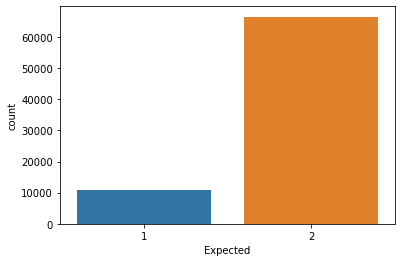

In [10]:
import seaborn as sns
sns.countplot(data=train, x="Expected")

In [11]:
#changing the datatype of 'Assay' to integer
train['Assay'] = train.Assay.astype(int)
test['Assay'] = test.Assay.astype(int)

In [12]:
#Dropping v1 and v2 column from train and test
train.drop(columns=['V1','V2'],inplace=True)
test.drop(columns=['V1', 'V2'],inplace=True)

In [13]:
#loading the features and target variables
x= train.drop(["Id","Expected"], axis=1)
y= train['Expected']

In [14]:
target= test.drop(["x","Id"], axis=1)

In [24]:
x.shape, target.shape

((77413, 945), (11139, 945))

In [15]:
# splitting the data using stratified k-fold
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits = 10,random_state = None, shuffle = False)

for train_index, test_index in folds.split(x,y):
    x_train, x_test, y_train, y_test = x.iloc[train_index], x.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

In [16]:
x_train.shape

(69672, 945)

In [17]:
#fitting the model using XGBClassifier
import xgboost as xgb
model = xgb.XGBClassifier(booster='gbtree',max_depth=8, n_estimators=400, random_state=22)
model.fit(x_train, y_train)
model.score(x_test,y_test)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:53:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.911122593980106

In [18]:
#predicting the test data based on the splitted data
y_pred= model.predict(x_test)

In [19]:
#checking the f1 score for internal validation
from sklearn.metrics import f1_score
f1= f1_score(y_test,y_pred,average = "macro")  #None, 'micro', 'macro', 'weighted', 'samples'
print(f1)

0.7972779607391741


In [20]:
#predicting the expected variable using target data from test.csv
y_target= model.predict(target)

In [21]:
#generating the output file
output_data = pd.DataFrame({'Id' : test.x, 'Predicted' : y_target})
output_data.to_csv('toxicity_prediction.csv', index = False)
print("Submission is successfully")

Submission is successfully
